In [7]:
import torch
import segmentation_models_pytorch as smp
import datetime
import numpy as np
import matplotlib.pyplot as plt
import json

# import my own modules
import datasets
from myUtils import *

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
res = 120
dataset = datasets.PlateDataset(res = res, train = True, npz_path='train_data.npz', multiply = 8)

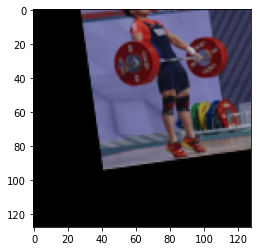

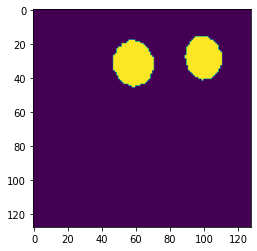

In [9]:
idx = np.random.randint(0, len(dataset))
obs = dataset[idx]

plt.imshow(obs[0].permute(1,2,0))
plt.show()
plt.imshow(obs[1].mean(0))
plt.show()

In [10]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=12)

In [11]:
ENCODER = 'timm-regnetx_002'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 2
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)
pytorch_total_params = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values())
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
with open('model_info.json') as f:
    model_info = json.load(f)
    
# if entry exists, use it
if model_info[f'{ENCODER}_model.pth'] != None:
    model = torch.load(f'{ENCODER}_model.pth')
    if model_info[f'{ENCODER}_model.pth']['total_epochs'] != None:
        total_epochs = model_info[f'{ENCODER}_model.pth']['total_epochs']
    else:
        total_epochs = 0
else:
    total_epochs = 0

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)
# append to file
score = [0]

n_epochs = 100
# percent complete, new learning rate
learning_rates = [
    (0, 1e-4),
    (0.4, 1e-5),
    (0.6, 1e-6),
    (0.8, 1e-7),
    (0.9, 1e-8),
    (0.95, 1e-9),
    (0.97, 1e-10),
]

optimizer.param_groups[0]['lr'] = learning_rates[0][1]
for i in range(0, n_epochs):
    print(f'\nEpoch: {i}')
    train_logs = train_epoch.run(dataloader)
    
    if train_logs['iou_score'] > score[-1]:
        torch.save(model, f'./{ENCODER}_model.pth')
            
        model_info[f'{ENCODER}_model.pth'] = {
            'params': pytorch_total_params,
            'iou_score': train_logs['iou_score'],
            'encoder': ENCODER,
            'input_size': [3, res,res],
            'out_size': [CLASSES,res,res],
            'weights': ENCODER_WEIGHTS,
            'activation': ACTIVATION,
            'total_epochs': total_epochs + i + 1,
        }
        
        with open('model_info.json', 'w') as f:
            json.dump(model_info, f, indent=4)

    score.append(train_logs['iou_score'])

    with open('./train.log', 'a') as f:
        f.write(f'{i} | {datetime.datetime.now()} | {str(train_logs)}\n')
        
    for percent, lr in learning_rates:
        if i == int(n_epochs * percent):
            optimizer.param_groups[0]['lr'] = lr
            print(f'\nNew learning rate: {lr}')
            break




Epoch: 0
train: 100%|██████████| 117/117 [00:15<00:00,  7.65it/s, dice_loss - 0.2208, iou_score - 0.6465]

New learning rate: 0.0001

Epoch: 1
train: 100%|██████████| 117/117 [00:15<00:00,  7.70it/s, dice_loss - 0.1455, iou_score - 0.7496]

Epoch: 2
train: 100%|██████████| 117/117 [00:14<00:00,  7.95it/s, dice_loss - 0.1266, iou_score - 0.7794]

Epoch: 3
train: 100%|██████████| 117/117 [00:15<00:00,  7.69it/s, dice_loss - 0.1162, iou_score - 0.7962]

Epoch: 4
train: 100%|██████████| 117/117 [00:15<00:00,  7.79it/s, dice_loss - 0.1098, iou_score - 0.8068]

Epoch: 5
train: 100%|██████████| 117/117 [00:14<00:00,  7.88it/s, dice_loss - 0.106, iou_score - 0.8128] 

Epoch: 6
train:   9%|▊         | 10/117 [00:01<00:17,  6.10it/s, dice_loss - 0.106, iou_score - 0.8125]


KeyboardInterrupt: 

In [14]:
model = torch.load(f'./{ENCODER}_model.pth').cuda()

In [15]:
pred = model(dataset[0][0].reshape((1, 3, res, res)).cuda())
pred = pred.detach().cpu().numpy()[0]
pred

RuntimeError: shape '[1, 3, 120, 120]' is invalid for input of size 49152

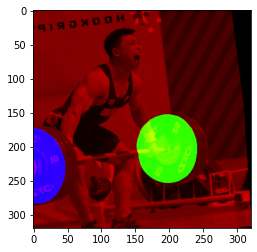

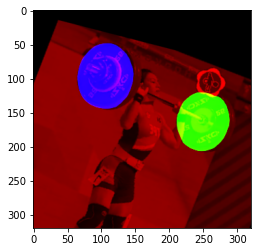

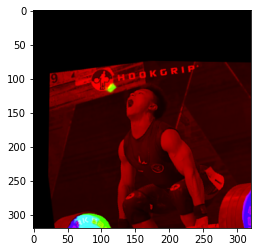

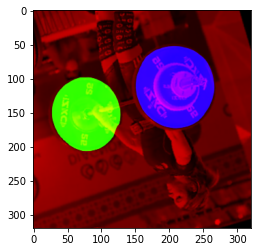

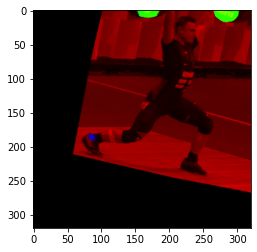

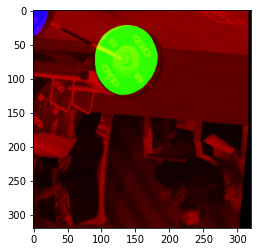

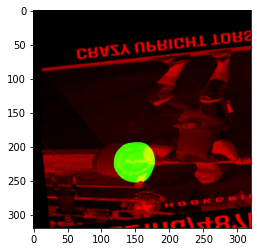

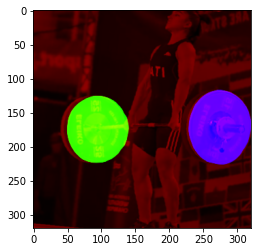

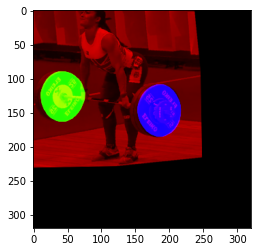

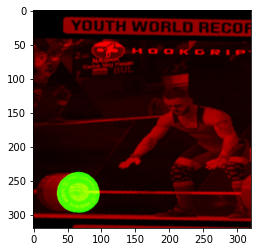

In [ ]:
for i in range(10):
    rand = np.random.randint(0, len(dataset))
    plot_pred(dataset[rand][0], model)

In [ ]:
import onnx